In [6]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Transformers
from transformers import AutoModel
from transformers.tokenization_utils_base import BatchEncoding

# PyTorch Geometric
from torch_geometric.data import Batch

# Data and metrics
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

import numpy as np


## 🔹 Load data

### Loads tokenized proteins, molecular graphs, and labels from `.pt` and `.csv` files for training and testing


In [ ]:
data_path = "./Train_Test_Data"

train_graphs = torch.load(f"{data_path}/train_graphs.pt", weights_only=False)
test_graphs = torch.load(f"{data_path}/test_graphs.pt", weights_only=False)

train_tokens = torch.load(f"{data_path}/train_tokens.pt", weights_only=False)
test_tokens = torch.load(f"{data_path}/test_tokens.pt", weights_only=False)

import pandas as pd
train_labels = pd.read_csv(f"{data_path}/train.csv")["label"].tolist()
test_labels = pd.read_csv(f"{data_path}/test.csv")["label"].tolist()


## 🔹Custom dataset and collate function for batching graphs and tokenized protein sequences


In [7]:

class DrugProteinDataset(Dataset):
    def __init__(self, graphs, tokens, labels):
        self.graphs = graphs
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {
            "graph": self.graphs[idx],
            "input_ids": token["input_ids"].squeeze(0),  # [seq_len]
            "attention_mask": token["attention_mask"].squeeze(0),  # [seq_len]
            "label": torch.tensor(self.labels[idx], dtype=torch.float)
        }

def custom_collate_fn(batch):
    graphs = Batch.from_data_list([item['graph'] for item in batch])
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True)
    labels = torch.stack([item['label'] for item in batch])

    return {
        "graph": graphs,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "label": labels
    }


## 🔹 ProteinCNN module
### processes ESM2 protein embeddings using a 1D CNN with batch norm, pooling, and dropout, outputting a fixed-size vector


In [8]:

class ProteinCNN(nn.Module):
    def __init__(self, input_channels=320, output_channels=64, kernel_size=3, stride=1, padding=1, dropout_rate=0.3):
        super(ProteinCNN, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(output_channels)  # Add batch norm
        self.conv2 = nn.Conv1d(output_channels, output_channels * 2, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(output_channels * 2)  # Add batch norm
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(output_channels * 2, 128)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout after conv1
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout after conv2
        self.dropout_fc = nn.Dropout(dropout_rate)  # Dropout before fc

    def forward(self, protein_embeddings):
        """
        protein_embeddings: Tensor of shape [batch_size, seq_len, embedding_dim]
                           → Output from ESM2 model's last_hidden_state
        """
        x = protein_embeddings.permute(0, 2, 1)  # [B, C, L]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)  #  Apply dropout to tensor
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)  # Apply dropout after conv2
        x = self.global_pool(x).squeeze(-1)  # [B, C]
        x = self.dropout_fc(x)  # Apply dropout before fc
        x = self.fc(x)  # [B, 128]
        return x

## 🔹GNNModel 
### applies two GCN layers with ReLU and dropout, followed by global mean pooling and a linear layer to extract molecular graph features


In [9]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(GNNModel, self).__init__()
        from torch_geometric.nn import GCNConv
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        from torch_geometric.nn import global_mean_pool
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


## 🔹 HybridModel

Combines drug and protein features via:

- **GNN** for molecular graphs  
- **Frozen ESM-2 + CNN** for protein sequences  
- **Fusion layer** for binary classification (activation vs. inhibition)


In [10]:

class HybridModel(nn.Module):
    def __init__(self, gnn_input_dim, gnn_output_dim, cnn_output_channels, pretrained_model_name="facebook/esm2_t6_8M_UR50D", freeze_esm=True, dropout_rate=0.3):
        super(HybridModel, self).__init__()

        # GNN
        #self.gnn = GNNModel(gnn_input_dim, gnn_output_dim, dropout_rate=dropout_rate)
        self.gnn = GNNModel(gnn_input_dim, hidden_dim=gnn_output_dim * 2, output_dim=gnn_output_dim, dropout_rate=dropout_rate)


        # ESM-2
        self.esm = AutoModel.from_pretrained(pretrained_model_name)
        if freeze_esm:
            for param in self.esm.parameters():
                param.requires_grad = False  # Properly freeze ESM-2
        self.freeze_esm = freeze_esm

        # CNN
        self.protein_cnn = ProteinCNN(input_channels=320, output_channels=cnn_output_channels, dropout_rate=dropout_rate)

        # Fusion
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout before fc
        self.fc = nn.Linear(gnn_output_dim + 128, 1)  # Changed to 2 for CrossEntropyLoss

    def forward(self, graph_data, input_ids, attention_mask):
        # GNN branch
        gnn_output = self.gnn(graph_data.x, graph_data.edge_index, graph_data.batch)

        # ESM-2 branch
        esm_output = self.esm(input_ids=input_ids, attention_mask=attention_mask)
        protein_embeddings = esm_output.last_hidden_state  # [B, L, 320]

        # CNN branch
        protein_output = self.protein_cnn(protein_embeddings)  # [B, 128]

        # Fusion
        combined_features = torch.cat((gnn_output, protein_output), dim=1)
        combined_features = self.dropout(combined_features)
        prediction = self.fc(combined_features)  # [B, 2]
        return prediction

## 🔹 Training Loop  
### Performs forward pass, loss calculation, backpropagation, and tracks accuracy


In [11]:
#Training Loop####

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in loader:
        graph_data = batch["graph"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(graph_data, input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


## 🔹 Evaluation Function  
### Computes average loss and accuracy on the test set using the trained model


In [12]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch in loader:
            graph = batch["graph"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(graph, input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

## 🔹 Model Training

### Trains the hybrid GNN + CNN model for 35 epochs with class imbalance handling. Logs train/test metrics each epoch and saves results to CSV


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load saved data
data_path = "./Train_Test_Data"
graphs = torch.load(f"{data_path}/train_graphs.pt", weights_only=False)
tokens = torch.load(f"{data_path}/train_tokens.pt", weights_only=False)
labels = pd.read_csv(f"{data_path}/train.csv")["label"].tolist()

train_dataset = DrugProteinDataset(graphs, tokens, labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)

test_graphs = torch.load(f"{data_path}/test_graphs.pt", weights_only=False)
test_tokens = torch.load(f"{data_path}/test_tokens.pt", weights_only=False)
test_labels = pd.read_csv(f"{data_path}/test.csv")["label"].tolist()

test_dataset = DrugProteinDataset(test_graphs, test_tokens, test_labels)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

# Model
model = HybridModel(gnn_input_dim=4, gnn_output_dim=128, cnn_output_channels=64, freeze_esm=True).to(device)
if model.freeze_esm:
    for param in model.esm.parameters():
        param.requires_grad = False

params = list(model.gnn.parameters()) + list(model.protein_cnn.parameters()) + list(model.fc.parameters())
optimizer = optim.Adam(params, lr=0.0005)
pos_weight = torch.tensor([2.33]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# === Log Training Results ===
results = []

num_epochs = 35
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    results.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc
    })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("training_metrics.csv", index=False)


##  🔹 Training Curves  
### Plots train/test loss and accuracy over 35 epochs using values saved from the training log


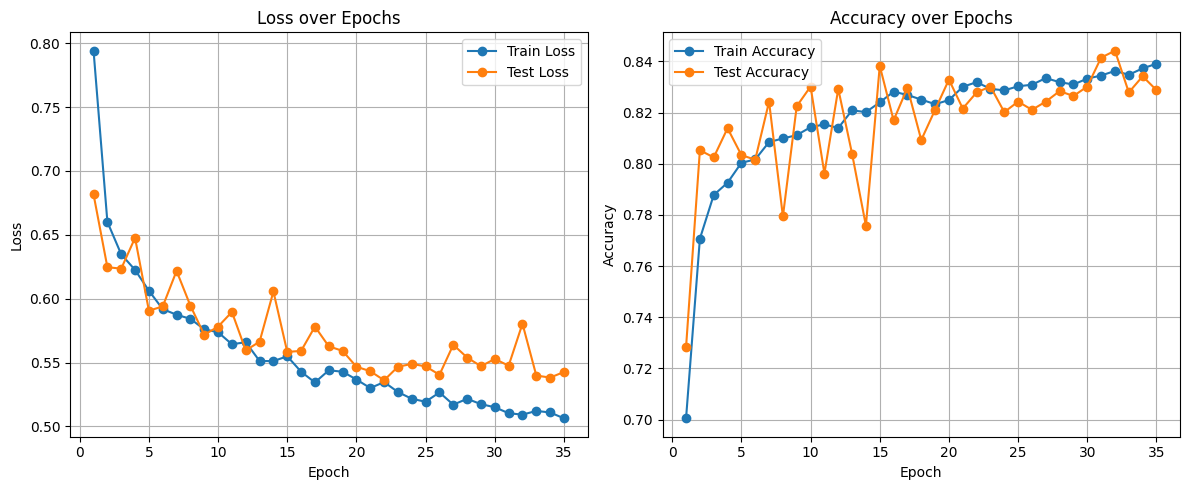

In [4]:
# Load your metrics
df = pd.read_csv("training_metrics.csv")

# Plot
plt.figure(figsize=(12, 5))

# === Loss ===
plt.subplot(1, 2, 1)
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", marker="o")
plt.plot(df["epoch"], df["test_loss"], label="Test Loss", marker="o")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# === Accuracy ===
plt.subplot(1, 2, 2)
plt.plot(df["epoch"], df["train_acc"], label="Train Accuracy", marker="o")
plt.plot(df["epoch"], df["test_acc"], label="Test Accuracy", marker="o")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 🔹 Final Evaluation (Epoch 35)  
### model was evaluated at epoch 35, where test accuracy and loss were near optimal and training was still stable  


In [21]:


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        graph = batch["graph"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(graph, input_ids, attention_mask).squeeze()
        probs = torch.sigmoid(outputs)

        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Threshold
binary_preds = [1 if p > 0.5 else 0 for p in all_preds]

# Print classification report
print(classification_report(all_labels, binary_preds, digits=4))

# Print AUC
print("AUC-ROC:", roc_auc_score(all_labels, all_preds))


              precision    recall  f1-score   support

         0.0     0.9245    0.7848    0.8489      1561
         1.0     0.6195    0.8454    0.7150       647

    accuracy                         0.8025      2208
   macro avg     0.7720    0.8151    0.7820      2208
weighted avg     0.8351    0.8025    0.8097      2208

AUC-ROC: 0.9051840307653618


## 🔹 Threshold Tuning  
### Finds best threshold (0.68–0.71) by maximizing weighted F1-score


In [26]:

thresholds = np.arange(0.68, 0.72, 0.01)
best_f1 = 0
best_thresh = 0.5
best_report = None

for t in thresholds:
    preds = (all_probs >= t).astype(int)
    report = classification_report(all_labels, preds, output_dict=True)
    f1 = report["weighted avg"]["f1-score"]  # or use "macro avg" if you prefer equal class weight

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
        best_report = report

# Print the report at the best threshold
print(f"🔧 Best threshold: {best_thresh:.2f}")
print("🧾 Classification report at best threshold:")
from pprint import pprint
pprint(best_report)


🔧 Best threshold: 0.69
🧾 Classification report at best threshold:
{'0.0': {'f1-score': 0.8879694462126034,
         'precision': 0.8823529411764706,
         'recall': 0.8936579115951313,
         'support': 1561.0},
 '1.0': {'f1-score': 0.7237048665620094,
         'precision': 0.7352472089314195,
         'recall': 0.7125193199381762,
         'support': 647.0},
 'accuracy': 0.8405797101449275,
 'macro avg': {'f1-score': 0.8058371563873064,
               'precision': 0.808800075053945,
               'recall': 0.8030886157666537,
               'support': 2208.0},
 'weighted avg': {'f1-score': 0.839835758244336,
                  'precision': 0.8392472306861861,
                  'recall': 0.8405797101449275,
                  'support': 2208.0}}


## 🔹 Final Evaluation Metrics (Epoch 35, Threshold = 0.69)

### 🔹 Per-Class Metrics

| Class            | Precision | Recall | F1-score | Support |
|------------------|-----------|--------|----------|---------|
| 0 (Inhibition)   | 0.8824    | 0.8937 | 0.8880   | 1561    |
| 1 (Activation)   | 0.7352    | 0.7125 | 0.7237   | 647     |

### 🔹 Overall Performance

| Metric              | Value   |
|---------------------|---------|
| **Accuracy**        | **84.06%** |
| Macro Precision     | 80.88%  |
| Macro Recall        | 80.31%  |
| Macro F1-score      | 80.58%  |
| Weighted F1-score   | 83.98%  |
| **AUC-ROC**         | **0.906** |
